Visoelastic Total/Grouped Data Viewer

In [ ]:
"""This function shows data grouped by plasticizer content"""
from pvc_tensile_experiment.Functions import *
def MonotonicDataViewer(plastiRatio):
    # define the folder name and pull the files that end with xlsx
    folderName = 'Monotonic Strain Rate Data'
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 12
    legendSize = 11

    # preallocate lists to store all the strain and stress per plasticizer content
    totalStrain = np.array(0)
    totalStress = np.array(0)

    for i in fileNames:
        # read and process the data file for strain and stress 
        _, strain, _, stress = ViscoelasticDataProcessor(folderName, i)

        # find each strain amplitude region
        regions = MonotonicStrainRateRegionSelector(strain)
        for j in range(0, 3):
            indexRange = range(regions[0, j], regions[1, j])
            strainFit = strain[indexRange] - strain[indexRange][0]
            stressFit = stress[indexRange] - stress[indexRange[0]]

            totalStrain = np.hstack([totalStrain, strainFit])
            totalStress = np.hstack([totalStress, stressFit])

    plt.scatter(totalStrain, totalStress, s = markerSize, label = f'{plastiRatio}')
    plt.xlabel('Strain (m/m)', fontsize = axisSize)
    plt.ylabel('Stress (Pa)', fontsize = axisSize)
    plt.title('Monotonic Strain Rate Fitting Region', fontsize = titleSize)
    plt.legend(fontsize = legendSize)

def RelaxationDataViewer(plastiRatio):
    # define the folder name and pull the files that end with xlsx
    folderName = 'Stress Relaxation Data'
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 12
    legendSize = 11

    # preallocate lists to store all the strain and stress per plasticizer content
    totalTime = np.array(0)
    totalNormStress = np.array(0)

    for i in fileNames:
        # read and process the data file for strain and stress 
        expTime, strain, _, stress = ViscoelasticDataProcessor(folderName, i)

        # the starting point is 4 before the maximum stress value
        regions = StressRelaxationRegionSelector(expTime, stress)

        for j in range(0, 3): 
            # extract the increasing strain regions. since the start is 5 indices from the maximum stress,
            # use these points to get the offset strain and stress
            indexRange = range(regions[0, j], regions[1, j])
            
            # get the stress vector offset
            expTimeOffset = expTime[indexRange][0]
            stressOffset = stress[indexRange][0]
            strainOffset = strain[indexRange][0]
            
            # reset the index range so the first data point is the maximum stress value.
            indexRange =  range(regions[0, j] + 5, regions[1, j])

            # define the variables 
            expTimeFit = expTime[indexRange] - expTimeOffset
            strainFit = strain[indexRange] - strainOffset
            stressFit = stress[indexRange] - stressOffset
            normStressFit = stressFit/strainFit

            totalTime = np.hstack([totalTime, expTimeFit])
            totalNormStress = np.hstack([totalNormStress, normStressFit])

    plt.scatter(totalTime, totalNormStress, s = markerSize, label = f'{plastiRatio}')

    plt.xlabel('Time (s)', fontsize = axisSize)
    plt.ylabel('Stress/Strain (Pa)', fontsize = axisSize)
    plt.title('Normalized Stress Relaxation Fitting Region', fontsize = titleSize)
    plt.legend(fontsize = legendSize)

for plastiRatio in ['P2', 'P4', 'P6', 'P8']:
   MonotonicDataViewer(plastiRatio)
plt.show()

for plastiRatio in ['P2', 'P4', 'P6', 'P8']:
   RelaxationDataViewer(plastiRatio)
plt.show()

Visoelastic Hysteresis

In [ ]:
"""This shows the hysteresis of a plasticizer"""
from pvc_tensile_experiment.Functions import *
def HysteresisDataViewer(plastiRatio):
    # define the folder name and pull the files that end with xlsx
    folderName = 'Monotonic Strain Rate Data'
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 9

    for i in fileNames:
        # read and process the data file for strain and stress 
        _, strain, _, stress = ViscoelasticDataProcessor(folderName, i)

        # find each strain amplitude region
        regions = MonotonicStrainRateRegionSelector(strain)
        for j in range(2, 3):
            indexRange = range(regions[0, j], regions[1, j] +  regions[1, j] - regions[0, j] + 7)
            strainFit = strain[indexRange] - strain[indexRange][0]
            stressFit = stress[indexRange] - stress[indexRange[0]]
            plt.plot(strainFit, stressFit, label = f' Trial: {i.removesuffix('.xlsx').split('_')[1]}')
    
    
    plt.xlabel('Strain (m/m)', fontsize = axisSize)
    plt.ylabel('Stress (Pa)', fontsize = axisSize)
    plt.title(f'{plastiRatio} Hysteresis at 30% Strain', fontsize = titleSize)
    plt.legend(fontsize = legendSize)

for plastiRatio in ['P2']:# 'P4', 'P6', 'P8']:
   HysteresisDataViewer(plastiRatio)
plt.show()

Stress Relaxation Fitting and Monotonic Stress Verification

SLS Model [116663.93946276   6395.10245366    951.17582992] 0.9641 

Prony 2-Term Model [116062.7710027    5057.67369778   1622.87352661   4905.03686718
    132.74889351] 0.981 

Prony 3-Term Model [1.15726976e+05 4.81529365e+03 2.08246405e+03 4.28091663e+03
 2.09685409e+02 1.00499314e+04 1.49769376e+01] 0.987 



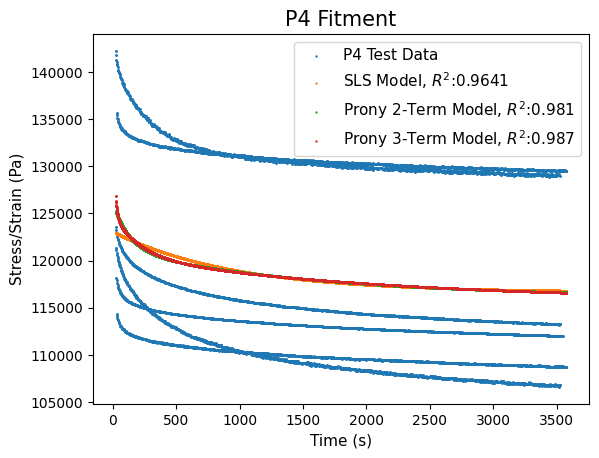

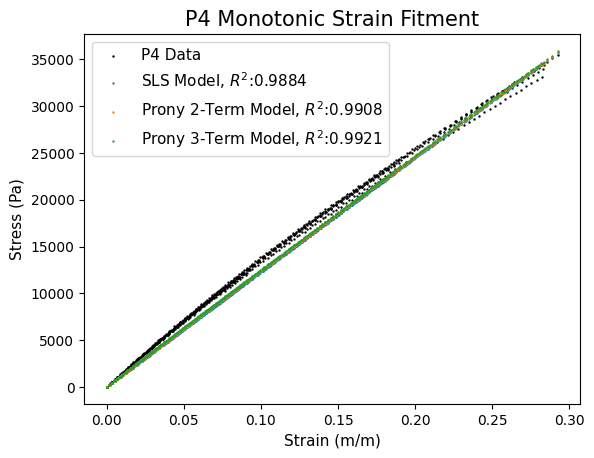

In [19]:
"""We use the normalized stress relaxation to fit the coefficeints of the 
    SLS and proney series then verify results using the monotonic strain 
    rate data"""
import numpy as np; import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
from pvc_tensile_experiment.Functions import *

def StressRelaxFitting(modelBoundaries, plastiRatio):
    # these equations are normalized to stress/strain
    def SLS(params, t):
        EInf, E1, tau = params
        return EInf + E1*np.exp(-t/tau)

    def Prony2Term(params, t):
        EInf, E1, tau1, E2, tau2 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)

    def Prony3Term(params, t):
        EInf, E1, tau1, E2, tau2, E3, tau3 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3)

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)


    # define the model fitting function
    def FitModel(model, t, stress, boundaries):
        # define the residual function and the NRMS function
        def Residuals(params):
            return model(params, t) - stress

        def NRMS(params):
            return np.sqrt(np.mean(Residuals(params)**2))/np.sqrt(np.mean(stress**2))

        # run the genetic algorithm first and use the results for the levenberg-marquardt solution
        optParams = opt.differential_evolution(NRMS, bounds = boundaries, popsize = 100).x
        return optParams

    # models and initial guesses
    models = {
        "SLS Model": (SLS, modelBoundaries[0]),
        "Prony 2-Term Model": (Prony2Term, modelBoundaries[1]), 
        "Prony 3-Term Model": (Prony3Term, modelBoundaries[2])
        }
    
    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 11

    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/Stress Relaxation Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # store the elongation regions to determine the coefficient of determination
    Data = np.zeros([0, 4])

    # define a dictionary to store the model coefficient
    fitResults = {}
    rSquared = []

    for name, (model, boundaries) in models.items():
        # determine the length of the coefficient parameters
        coefficientParameters = len(boundaries)

        # define array for the average coefficients from all datasets
        FitCoefficients = np.zeros([0, coefficientParameters])
        
        for i in fileNames:
            # read and process the data file for strain and stress 
            expTime, strain, _, stress = ViscoelasticDataProcessor('Stress Relaxation Data', i)
            
            # the starting point is 4 before the maximum stress value
            regions = StressRelaxationRegionSelector(expTime, stress)

            for j in range(0, 2):
                # extract the increasing strain regions. since the start is 5 indices from the maximum stress,
                # use these points to get the offset strain and stress
                indexRange = range(regions[0, j], regions[1, j])
                
                # get the stress vector offset
                expTimeOffset = expTime[indexRange][0]
                stressOffset = stress[indexRange][0]
                strainOffset = strain[indexRange][0]
                
                # reset the index range so the first data point is the maximum stress value.
                indexRange =  range(regions[0, j] + 5, regions[1, j])

                # define the variables 
                expTimeFit = expTime[indexRange] - expTimeOffset
                strainFit = strain[indexRange] - strainOffset
                stressFit = stress[indexRange] - stressOffset
                normStressFit = stressFit/strainFit

                # fit each data set for normalized stress
                for i in range(0, 3):
                    params = FitModel(model, expTimeFit, normStressFit, boundaries)
                    FitCoefficients = np.vstack([FitCoefficients, params])
                    rSquared.append(RSquared(normStressFit, models[name][0](params, expTimeFit)))

                # store stress and strain into arrays for data fitting.
                Data = np.vstack([Data, np.array([expTimeFit, strainFit, stressFit, normStressFit]).T])

        # sort data based on time 
        Data = Data[Data[::, 0].argsort()]

        # average the fitted coefficients and store them
        fitResults[name] = (np.mean(FitCoefficients, axis = 0), np.round(np.mean(rSquared), 4))

        # show the results
        print(name, fitResults[name][0], fitResults[name][1], '\n')


    # plot the fitment region
    plt.scatter(Data[::, 0], Data[::, 3], s = markerSize, label = f'{plastiRatio} Test Data')

    # preallocate data store matrices. the dictionary needs to have the data separated.
    df = pd.DataFrame(columns = ['RSquared', 'EInf', 'E1', 'Tau1', 'E2', 'Tau2', 'E3', 'Tau3'])
    data = np.zeros([0, 8], dtype = object)
    modelName = []

    # plot the model
    for name, (params, rSquared) in fitResults.items():
        # plot the fitted results
        plt.scatter(Data[::, 0], models[name][0](fitResults[name][0], Data[::, 0]), s = markerSize, label = f'{name}, $R^2$:{fitResults[name][1]}')
        plt.xlabel('Time (s)', fontsize = axisSize)
        plt.ylabel('Stress/Strain (Pa)', fontsize = axisSize)
        plt.title(f'{plastiRatio} Fitment', fontsize = titleSize)
        plt.legend(fontsize = legendSize)

        # fill the data array for fitment
        modelName.append(name)
        params = np.hstack([np.round(params, 0), np.zeros([7 - len(params)])]) 
        data = np.vstack([data, np.insert(params, 0, np.round(rSquared, 4))])
    plt.show()

    # populate the dataframe and save the data in csv
    df = pd.DataFrame(data, columns = ['RSquared', 'EInf', 'E1', 'Tau1', 'E2', 'Tau2', 'E3', 'Tau3'])
    df.insert(0, 'Models', modelName)
    df.to_csv(f'Data/{plastiRatio} PVC Gel Viscoelastic Parameters.csv', header = True, index = None)


def MonotonicStressVerification(plastiRatio):

    # define the SLS, Prony series, and coefficient of determination functions
    # these are in terms of stress
    def SLSStrainRate(params, strain):
        EInf, E1, tau = params
        return EInf*strain + E1*tau*strainRateFit*(1 - np.exp(-strain/(tau*strainRateFit))) 

    def Prony2TermStrainRate(params, strain):
        EInf, E1, tau1, E2, tau2 = params

        return (EInf*strain +
                E1*tau1*strainRateFit*(1 - np.exp(-strain/(tau1*strainRateFit))) +
                E2*tau2*strainRateFit*(1 - np.exp(-strain/(tau2*strainRateFit))))

    def Prony3TermStrainRate(params, strain):
        EInf, E1, tau1, E2, tau2, E3, tau3 = params
        return (EInf*strain +
                E1*tau1*strainRateFit*(1 - np.exp(-strain/(tau1*strainRateFit))) +
                E2*tau2*strainRateFit*(1 - np.exp(-strain/(tau2*strainRateFit))) +
                E3*tau3*strainRateFit*(1 - np.exp(-strain/(tau3*strainRateFit))))

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)


    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir('Data/Viscoelastic Data/Monotonic Strain Rate Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # store the elongation regions to determine the coefficient of determination
    Data = np.zeros([0, 3])

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 11

    # read each file, extracting the increasing strain region and save all to a set of arrays
    for i in fileNames:
        # read and process the data file for strain and stress 
        _, strain, strainRate, stress = ViscoelasticDataProcessor('Monotonic Strain Rate Data', i)

        # find each strain amplitude region
        regions = MonotonicStrainRateRegionSelector(strain)
        
        for j in range(0, 3):
            # extract the increasing strain regions
            indexRange = range(regions[0, j], regions[1, j])
            strainFit = strain[indexRange] - strain[indexRange][0]
            strainRateFit = strainRate[indexRange]
            stressFit = stress[indexRange] - stress[indexRange][0]

            # store stress and strain into arrays for data fitting.
            Data = np.vstack([Data, np.array([strainFit, strainRateFit, stressFit]).T])

    # reorganize the data
    Data = Data[Data[::, 0].argsort()]

    # define the strain rate fit for the functions
    strainRateFit = Data[::, 1]

    # plot data results
    plt.scatter(Data[::, 0], Data[::, 2], s = markerSize, color = "black", label = f'{plastiRatio} Data')

    # find the coefficients for each equation
    fileNames = [i for i in os.listdir('Data/') if i.endswith('.csv') and i.find(plastiRatio) != -1][0]
    fitResults = pd.read_csv(f"Data/{fileNames}").to_numpy()

    # models and initial guesses
    models = {
        "SLS Model": (SLSStrainRate, fitResults[0, np.nonzero(fitResults[0,:])[0]][2:]),
        "Prony 2-Term Model": (Prony2TermStrainRate, fitResults[1, np.nonzero(fitResults[1,:])[0]][2:]), 
        "Prony 3-Term Model": (Prony3TermStrainRate, fitResults[2, np.nonzero(fitResults[2,:])[0]][2:])
        }

    for name, (modelEqu, params) in models.items():
        plt.scatter(Data[::, 0], modelEqu(params, Data[::, 0]), s = markerSize, label = f'{name}, $R^2$:{np.round(RSquared(Data[::, 2], modelEqu(params, Data[::, 0])), 4)}')
        plt.xlabel('Strain (m/m)', fontsize = axisSize)
        plt.ylabel('Stress (Pa)', fontsize = axisSize)
        plt.title(f'{plastiRatio} Monotonic Strain Fitment', fontsize = titleSize)
        plt.legend(fontsize = legendSize)

# # P2 boundaries
# modelBoundaries = list([[(1e5, 1e6), (0.5e4, 1e5), (500, 1200)], # SLS
#                         [(1e5, 1e6), (0.5e4, 1e5), (1000, 2000), (1e3, 1e5), (50, 200)], # Proney 2 term
#                         [(1e5, 1e6), (0.5e4, 1e5), (1000, 2000), (1e3, 1e5), (90, 200), (1e3, 1e5), (20, 100)] # Proney 3 term
#                         ])

# P4 boundaries
modelBoundaries = list([[(1e4, 5e5), (1e3, 1e4), (800, 1500)], # SLS
                        [(1e4, 5e5), (1e3, 1e4), (1200, 2200), (0.5e3, 5e4), (50, 200)], # Proney 2 term
                        [(1e4, 5e5), (1e3, 1e4), (1700, 2700), (1e3, 1e5), (150, 295), (1e4, 2e5), (10, 50)] # Proney 3 term
                        ])

# # P6 boundaries
# modelBoundaries = list([[(1e4, 1e5), (1e2, 5e3), (600, 1500)], # SLS
#                         [(1e4, 5e5), (1e2, 1e4), (1300, 2000), (1e2, 1e4), (50, 200)], # Proney 2 term
#                         [(1e4, 1e5), (1e2, 1e4), (1800, 2700), (1e2, 1e4), (125, 275), (1e2, 1.5e4), (3, 50)] # Proney 3 term
#                         ])

# # P8 boundaries
# modelBoundaries = list([[(1e3, 5e4), (10, 1e3), (600, 1500)], # SLS
#                         [(1e4, 5e5), (10, 1e3), (1000, 2300), (1e2, 1e4), (60, 200)], # Proney 2 term
#                         [(1e4, 1e5), (1e2, 1e4), (1800, 2700), (1e2, 1e4), (125, 275), (1e2, 1e4), (5, 50)]
#                         ]) # Proney 3 term
 
# P2, P4, and P8 are done.
plastiRatio = 'P4'
StressRelaxFitting(modelBoundaries, plastiRatio)
MonotonicStressVerification(plastiRatio)

Concentration Dependance

In [ ]:
from pvc_tensile_experiment.Functions import *
import pandas as pd; import numpy as np
from scipy.optimize import curve_fit

def LinearFit(x, a, b):
    return a*x + b

# Compute R-squared
def RSquared(yTrue, yPredict):
    ssResidual = np.sum((yTrue - yPredict)**2)
    ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
    return 1 - (ssResidual/ssTotal)



# find the names of the viscoelastic functions
fileNames = [i for i in os.listdir('Data') if i.endswith('.csv')][0:-1]

# express the concentrations as log base 10. Make each repeat 3 times,
# one for each model.
# concentration = np.repeat(np.log10([np.array([2, 4, 6, 8])]), 3)
concentration = np.log10(np.array([25.6, 14.6, 10.3, 7.9]))
# concentration = np.repeat(np.log10([np.array([1/2, 1/4, 1/6, 1/8])]), 3)


# preallocate the data dataframe
data = pd.DataFrame(columns = ['Models', 'EInf', 'E1', 'E2', 'E3'])
for i in fileNames:
    # read the modulus from each model, ignoring the time constants. 
    # add to the data dataframe
    modulus = pd.read_csv(f'Data/{i}', usecols = [0, 2, 3, 5, 7])
    data = pd.concat([data, modulus], ignore_index = True)

# convert each modulus to log base 10. convert -inf to empty
data['EInf'] = np.log10(data['EInf'])
data['E1'] = np.log10(data['E1'])
data['E2'] = np.log10(data['E2'])
data['E3'] = np.log10(data['E3'])
data.replace([np.inf, -np.inf], np.empty, inplace = True)

# add a concentration column 
data.insert(0, 'Plasticizer', concentration)

# plot parameters
markerSize = 2
titleSize = 15
axisSize = 12
legendSize = 11

# identify each model
SLSModel = data[data['Models'] == 'SLS Model']
Proney2TermModel = data[data['Models'] == 'Prony 2-Term Model']
Proney3TermModel = data[data['Models'] == 'Prony 3-Term Model']

# create a dictionary to fit the modulus
models = {'EInf': Proney3TermModel['EInf'],
          'E1': Proney3TermModel['E1'],
          'E2': Proney3TermModel['E2'],
          'E3': Proney3TermModel['E3'],
          }

# create a dictionary to story the fitted modulus
fitResults = {}

for term, (values) in models.items():
    params, _ = curve_fit(LinearFit, Proney3TermModel['Plasticizer'].to_numpy(), values)
    print()
    r2 = RSquared(values, LinearFit(Proney3TermModel['Plasticizer'].to_numpy(), params[0], params[1]))
    fitResults[term] = (params, r2)

# Proney3TermModel model evaluation.
plt.scatter(Proney3TermModel['Plasticizer'], Proney3TermModel['EInf'], s = markerSize, label = f'E$_I$$_n$$_f$, r$^2$ = {np.round(fitResults['EInf'][1], 4)}')
plt.plot(Proney3TermModel['Plasticizer'], LinearFit(Proney3TermModel['Plasticizer'].to_numpy(), fitResults['EInf'][0][0], fitResults['EInf'][0][1]))

plt.scatter(Proney3TermModel['Plasticizer'], Proney3TermModel['E1'], s = markerSize, label = f'E$_1$, r$^2$ = {np.round(fitResults['E1'][1], 4)}')
plt.plot(Proney3TermModel['Plasticizer'], LinearFit(Proney3TermModel['Plasticizer'].to_numpy(), fitResults['E1'][0][0], fitResults['E1'][0][1]))

plt.scatter(Proney3TermModel['Plasticizer'], Proney3TermModel['E2'], s = markerSize, label = f'E$_2$, r$^2$ = {np.round(fitResults['E2'][1], 4)}')
plt.plot(Proney3TermModel['Plasticizer'], LinearFit(Proney3TermModel['Plasticizer'].to_numpy(), fitResults['E2'][0][0], fitResults['E2'][0][1]))

plt.scatter(Proney3TermModel['Plasticizer'], Proney3TermModel['E3'], s = markerSize, label = f'E$_3$, r$^2$ = {np.round(fitResults['E3'][1], 4)}')
plt.plot(Proney3TermModel['Plasticizer'], LinearFit(Proney3TermModel['Plasticizer'].to_numpy(), fitResults['E3'][0][0], fitResults['E3'][0][1]))

plt.xlabel('Log$_1$$_0$(Concentration Ratio)', fontsize = axisSize)
plt.ylabel('Log$_1$$_0$(Elastic Modulus) (Pa)', fontsize = axisSize)
plt.title('3 Term Prony Series Modulus-Concentration Relationship', fontsize = titleSize)
plt.legend(fontsize = legendSize)


MISC. & Old Functions

Viscoelastic Monotonic Strain Rate Fitting

In [ ]:
import numpy as np; import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
from pvc_tensile_experiment.Functions import *


def MonotonicStressFitting(modelBoundaries, plastiRatio):
    # define the SLS, Prony series, and coefficient of determination functions
    # these are in terms of stress
    def SLSStrainRate(params, strain):
        EInf, E1, tau = params
        return EInf*strain + E1*tau*strainRateFit*(1 - np.exp(-strain/(tau*strainRateFit))) 

    def Prony2TermStrainRate(params, strain):
        EInf, E1, tau1, E2, tau2 = params

        return (EInf*strain +
                E1*tau1*strainRateFit*(1 - np.exp(-strain/(tau1*strainRateFit))) +
                E2*tau2*strainRateFit*(1 - np.exp(-strain/(tau2*strainRateFit))))

    def Prony3TermStrainRate(params, strain):
        EInf, E1, tau1, E2, tau2, E3, tau3 = params
        return (EInf*strain +
                E1*tau1*strainRateFit*(1 - np.exp(-strain/(tau1*strainRateFit))) +
                E2*tau2*strainRateFit*(1 - np.exp(-strain/(tau2*strainRateFit))) +
                E3*tau3*strainRateFit*(1 - np.exp(-strain/(tau3*strainRateFit))))

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)

    # define the model fitting function
    def FitModel(model, strain, stress, boundaries):
        # define the residual function and the NRMS function
        def Residuals(params):
            return model(params, strain) - stress

        def NRMS(params):
            return np.sqrt(np.mean(Residuals(params)**2))/np.sqrt(np.mean(stress**2))

        # run the genetic algorithm first and use the results for the levenberg-marquardt solution
        optParams = opt.differential_evolution(NRMS, bounds = boundaries, popsize = 100).x
        return optParams

    # models and initial guesses
    models = {
        "SLS Model": (SLSStrainRate, modelBoundaries[0]),
        "Prony 2-Term Model": (Prony2TermStrainRate, modelBoundaries[1]), 
        "Prony 3-Term Model": (Prony3TermStrainRate, modelBoundaries[2])
        }


    # define the folder name and pull the files that end with xlsx
    fileNames = [i for i in os.listdir('Data/Viscoelastic Data/Monotonic Strain Rate Data') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # store the elongation regions to determine the coefficient of determination
    Data = np.zeros([0, 3])

    # define a dictionary to store the model coefficient
    fitResults = {}
    rSquared = []

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 11

    for name, (model, boundaries) in models.items():
        # determine the length of the coefficient parameters
        coefficientParameters = len(boundaries)

        # define array for the average coefficients from all datasets
        FitCoefficients = np.zeros([0, coefficientParameters])

        # read each file, extracting the increasing strain region and save all to a set of arrays
        for i in fileNames:
            # read and process the data file for strain and stress 
            _, strain, strainRate, stress = ViscoelasticDataProcessor('Monotonic Strain Rate Data', i)

            # find each strain amplitude region
            regions = MonotonicStrainRateRegionSelector(strain)
            
            for j in range(0, 3):
                # extract the increasing strain regions
                indexRange = range(regions[0, j], regions[1, j])
                strainFit = strain[indexRange] - strain[indexRange][0]
                strainRateFit = strainRate[indexRange]
                stressFit = stress[indexRange] - stress[indexRange][0]

                # store stress and strain into arrays for data fitting.
                Data = np.vstack([Data, np.array([strainFit, strainRateFit, stressFit]).T])
                    
                
                for i in range(0, 3):
                    # run the data fitment for increasing strain regions
                    params = FitModel(model, strainFit, stressFit, boundaries)
                    FitCoefficients = np.vstack([FitCoefficients, params])
                    rSquared.append(RSquared(stressFit, models[name][0](params, strainFit)))

            
        # average the fitted coefficients
        params = np.average(FitCoefficients, axis = 0)

        # redefine the strainRateFit from the stored data. its passed to make sure the functions work
        fitResults[name] = (params, np.round(np.mean(rSquared), 4))
        
        # show the results
        print(name, fitResults[name][0], fitResults[name][1], '\n')


    # average the strain rate for the functions
    strainRateFit = np.average(Data[::, 1])

    # plot data results
    plt.scatter(Data[::, 0], Data[::, 2], s = markerSize, color = "black")

    for name, (params) in fitResults.items():
        plt.scatter(Data[::, 0], models[name][0](fitResults[name][0], Data[::, 0]), s = markerSize, label = f'{name}, $R^2$:{fitResults[name][1]}')
        plt.xlabel('Strain (m/m)', fontsize = axisSize)
        plt.ylabel('Stress (Pa)', fontsize = axisSize)
        plt.title(f'{plastiRatio} Fitment', fontsize = titleSize)
        plt.legend(fontsize = legendSize)
    return Data, fitResults

Data, fitResults = MonotonicStressFitting(modelBoundaries, 'P2')

Stress Relaxation Verification

In [ ]:
def StressRelaxation(plastiRatio, fitResults):
        # these equations are normalized to stress/strain
    def SLS(params, t):
        EInf, E1, tau = params
        return EInf + E1*np.exp(-t/tau)

    def Prony2Term(params, t):
        EInf, E1, tau1, E2, tau2 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2)

    def Prony3Term(params, t):
        EInf, E1, tau1, E2, tau2, E3, tau3 = params
        return EInf + E1*np.exp(-t/tau1) + E2*np.exp(-t/tau2) + E3*np.exp(-t/tau3)

    def RSquared(yTrue, yPredict):
        ssResidual = np.sum((yTrue - yPredict)**2)
        ssTotal = np.sum((yTrue - np.mean(yTrue))**2)
        return 1 - (ssResidual/ssTotal)


    # define the folder and find the files for strain relaxation
    folderName = 'Stress Relaxation Data'
    fileNames = [i for i in os.listdir(f'Data/Viscoelastic Data/{folderName}') if i.endswith('.xlsx') and i.find(plastiRatio) != -1]

    # preallocate the total data matrix
    Data = np.zeros([0, 4])

    # plot parameters
    markerSize = 0.5
    titleSize = 15
    axisSize = 11
    legendSize = 11
    
    for i in fileNames:
        # read and process the data file for strain and stress 
        expTime, strain, _, stress = ViscoelasticDataProcessor('Stress Relaxation Data', i)
        regions = StressRelaxationRegionSelector(strain)

        for j in range(0, 3):
            # extract the increasing strain regions
            indexRange = range(regions[0, j], regions[1, j])
            
            # get the stress vector offset
            expTimeOffset = expTime[indexRange][0]
            stressOffset = stress[indexRange][0]
            strainOffset = strain[indexRange][0]
            
            # reset the index range to not include the first 2 data points, removing the non values.
            indexRange =  range(regions[0, j] + 7, regions[1, j])

            # define the variables 
            expTimeFit = expTime[indexRange] - expTimeOffset
            strainFit = strain[indexRange] - strainOffset
            stressFit = stress[indexRange] - stressOffset
            normStressFit = stressFit/strainFit

            # store stress and strain into arrays for data fitting.
            Data = np.vstack([Data, np.array([expTimeFit, strainFit, stressFit, normStressFit]).T])

    expTimeFit = Data[::, 0]
    strainFit = Data[::, 1]
    stressFit = Data[::, 2]
    normStressFit = Data[::, 3]

    # plot the fitment region
    plt.scatter(expTimeFit, normStressFit, s = markerSize, label = f'{plastiRatio} Test Data')

    # plot the fit results for each function
    plt.scatter(expTimeFit, SLS(fitResults['SLS Model'][0], expTimeFit), s = 2, label = 'SLS')
    print(RSquared(normStressFit, SLS(fitResults['SLS Model'][0], expTimeFit)))

    plt.scatter(expTimeFit, Prony2Term(fitResults['Prony 2-Term Model'][0], expTimeFit), s = 2, label = 'Prony 2 Term')
    print(RSquared(normStressFit, Prony2Term(fitResults['Prony 2-Term Model'][0], expTimeFit)))
    
    plt.scatter(expTimeFit, Prony3Term(fitResults['Prony 3-Term Model'][0], expTimeFit), s = 2, label = 'Prony 3 Term')
    print(RSquared(normStressFit, Prony3Term(fitResults['Prony 3-Term Model'][0], expTimeFit)))

    plt.xlabel('Time (s)', fontsize = axisSize)
    plt.ylabel('Stress (Pa)/Strain', fontsize = axisSize)
    plt.title(f'{fileNames[0].removesuffix('.xlsx').split('_')[0]} Fit', fontsize = titleSize)
    plt.legend(fontsize = legendSize)


StressRelaxation('P2', fitResults)